# Bahan Ajar: Training **Small CNN + Data Augmentasi** pada **FashionMNIST** (PyTorch)

Notebook ini fokus pada:
1. Menyiapkan **dataset FashionMNIST** + **augmentasi** (hanya untuk data train).
2. Menampilkan **contoh hasil augmentasi** (1 gambar → banyak variasi).
3. Melatih **Small CNN** yang sesuai untuk input **grayscale 28×28** (tanpa resize besar).
4. Evaluasi: **akurasi, loss, confusion matrix, classification report**.
5. Menyajikan **tabel arsitektur**: *Layer | Input Shape | Output Shape | Catatan*.


## Setup & Import

Jalankan cell ini untuk menyiapkan library, seed, dan device.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Matplotlib default (tanpa set warna khusus)
plt.rcParams["figure.figsize"] = (7, 5)


Device: cuda


## 1. Dataset FashionMNIST + Transform (Augmentasi)

Prinsip yang dipakai:
- **Train transform**: berisi augmentasi (misal rotasi ringan, crop dengan padding, affine translate/scale, dan random erasing).
- **Val/Test transform**: tanpa augmentasi (hanya ToTensor + Normalize).

Kenapa?
- Augmentasi membantu model belajar fitur yang lebih **robust** terhadap variasi wajar (posisi/rotasi kecil/noise).

In [ ]:
import os
from torch.utils.data import Subset

# Normalisasi yang sering dipakai untuk FashionMNIST
# mean ~ 0.286, std ~ 0.353
MEAN = (0.2860,)
STD  = (0.3530,)

# -------------------------
# 1) Transform Train (dengan augmentasi)
# -------------------------
train_transform = transforms.Compose([
    # Augmentasi geometri ringan
    transforms.RandomCrop(28, padding=4),             # translasi kecil via padding+crop
    transforms.RandomRotation(degrees=10),            # rotasi lebih kecil (lebih stabil)
    transforms.RandomAffine(
        degrees=0,
        translate=(0.08, 0.08),                       # geser max 8%
        scale=(0.95, 1.05)                            # zoom kecil
    ),

    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),

    # Regularisasi berbasis input (opsional tapi sering efektif)
    transforms.RandomErasing(
        p=0.25,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.3),
        value="random"
    )
])

# -------------------------
# 2) Transform Val/Test (tanpa augmentasi)
# -------------------------
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# -------------------------
# 3) Load dataset
# -------------------------
data_root = "./data"

full_train_aug   = datasets.FashionMNIST(root=data_root, train=True,  download=True, transform=train_transform)
full_train_noaug = datasets.FashionMNIST(root=data_root, train=True,  download=True, transform=test_transform)
full_test        = datasets.FashionMNIST(root=data_root, train=False, download=True, transform=test_transform)
class_names = full_train_aug.classes
# Split Train/Val dari train set (misal 55k/5k)
val_size = 5000
train_size = len(full_train_aug) - val_size

g = torch.Generator().manual_seed(42)
train_split, val_split = random_split(range(len(full_train_aug)), [train_size, val_size], generator=g)

train_ds = Subset(full_train_aug,   train_split.indices)   # train pakai augmentasi
val_ds   = Subset(full_train_noaug, val_split.indices)     # val tanpa augmentasi

# -------------------------
# 4) DataLoader
# -------------------------
batch_size  = 32
num_workers = 0

pin = (device.type == "cuda")
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)
test_loader  = DataLoader(full_test,batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(full_test)}")
print(f"Device: {device} | batch_size={batch_size} | num_workers={num_workers} | pin_memory={pin}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 190kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.47MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.6MB/s]


Train: 55000 | Val: 5000 | Test: 10000
Device: cuda | batch_size=32 | num_workers=0 | pin_memory=True


## 2. Contoh Visual Hasil Augmentasi

Kita ambil **1 gambar yang sama** dari dataset (sebelum normalisasi untuk visual), lalu terapkan transform train berulang kali untuk melihat variasinya.

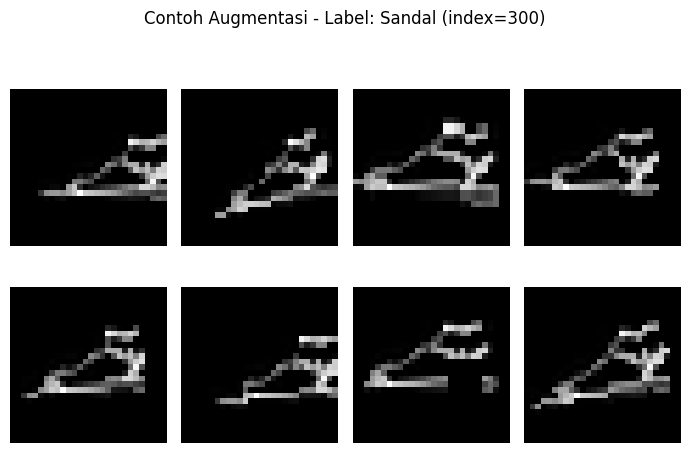

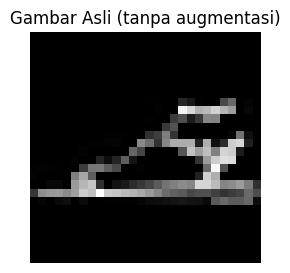

In [ ]:
# Transform khusus untuk VISUALISASI:
# Sama seperti train_transform, tapi TANPA normalize supaya gampang dilihat.
train_transform_vis = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.10, 0.10), scale=(0.90, 1.10)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),
])

# Dataset mentah untuk ambil PIL image asli (tanpa transform)
raw_train = datasets.FashionMNIST(root=data_root, train=True, download=False, transform=None)

idx = 300 # ganti index bila ingin contoh lain
pil_img, label = raw_train[idx]
label_name = class_names[label]

n_show = 8
fig, axes = plt.subplots(2, 4)
fig.suptitle(f"Contoh Augmentasi - Label: {label_name} (index={idx})")

for i, ax in enumerate(axes.flatten()):
    x = train_transform_vis(pil_img)  # tensor (1, 28, 28)
    ax.imshow(x.squeeze(0), cmap="gray")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Tampilkan juga gambar asli
plt.figure(figsize=(3,3))
plt.title("Gambar Asli (tanpa augmentasi)")
plt.imshow(np.array(pil_img), cmap="gray")
plt.axis("off")
plt.show()


## 3. Definisi Model: Small CNN + Batch Normalization

Desain sederhana namun kuat untuk **28×28 grayscale**:
- 2 blok konvolusi: **Conv → BatchNorm → ReLU → Conv → BatchNorm → ReLU → Pool**
- Dropout untuk regularisasi
- Head klasifikasi: **Flatten → Linear → BatchNorm → ReLU → Dropout → Linear (10 kelas)**

Kenapa BatchNorm ditambahkan?
- Menstabilkan distribusi aktivasi di tiap mini-batch, sehingga training biasanya lebih stabil dan cepat konvergen.


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()

        # Feature extractor
        # Urutan umum = Conv -> BatchNorm -> ReLU
        self.features = nn.Sequential(
            # Block 1 (input: 1x28x28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),      # 28x28 -> 14x14
            nn.Dropout(p=0.20),

            # Block 2 (input: 32x14x14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),      # 14x14 -> 7x7
            nn.Dropout(p=0.25),

            # Block 3 (input: 64x7x7)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),      # 7x7 -> 3x3
            nn.Dropout(p=0.25),

            # Pooling agar head ringkas
            nn.AdaptiveAvgPool2d((1, 1))      # 128x3x3 -> 128x1x1
        )

        # Classifier (head)
        self.classifier = nn.Sequential(
            nn.Flatten(),                     # 128
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.30),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN(num_classes=10).to(device)

# Hitung jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parameter:", total_params)
print("Trainable parameter:", trainable_params)


Total parameter: 305386
Trainable parameter: 305386


## 4. Tabel Arsitektur: Layer | Input Shape | Output Shape | Catatan

Di bawah ini ada fungsi kecil untuk melakukan *forward* pada dummy input `(1, 1, 28, 28)` dan mencatat bentuk input-output tiap layer (leaf module).

In [ ]:
import pandas as pd

def layer_note(m: nn.Module) -> str:
    # Catatan ringkas agar cocok untuk bahan ajar
    if isinstance(m, nn.Conv2d):
        return f"Conv2d k={m.kernel_size}, s={m.stride}, p={m.padding}, out={m.out_channels}"
    if isinstance(m, nn.BatchNorm2d):
        return f"BatchNorm2d num_features={m.num_features}"
    if isinstance(m, nn.BatchNorm1d):
        return f"BatchNorm1d num_features={m.num_features}"
    if isinstance(m, nn.MaxPool2d):
        return f"MaxPool k={m.kernel_size}, s={m.stride}"
    if isinstance(m, nn.Linear):
        return f"Linear in={m.in_features} → out={m.out_features}"
    if isinstance(m, nn.Dropout):
        return f"Dropout p={m.p}"
    if isinstance(m, nn.ReLU):
        return "ReLU"
    if isinstance(m, nn.Flatten):
        return "Flatten"
    return m.__class__.__name__


def summarize_model(model: nn.Module, input_size=(1, 28, 28), device=device) -> pd.DataFrame:
    records = []
    hooks = []

    def register_hook(module, name):
        def hook(module, inp, out):
            # inp/out bisa tuple
            in_shape = tuple(inp[0].shape) if isinstance(inp, (tuple, list)) else tuple(inp.shape)
            out_shape = tuple(out.shape) if hasattr(out, "shape") else str(type(out))
            records.append({
                "Layer": name,
                "Input Shape": str(in_shape),
                "Output Shape": str(out_shape),
                "Catatan": layer_note(module),
            })
        return module.register_forward_hook(hook)

    # Pasang hook hanya pada "leaf module" (tidak punya children)
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            hooks.append(register_hook(module, name))

    model.eval()
    with torch.no_grad():
        dummy = torch.zeros((1, *input_size), device=device)
        _ = model(dummy)

    for h in hooks:
        h.remove()

    return pd.DataFrame(records)

arch_df = summarize_model(model, input_size=(1, 28, 28), device=device)
arch_df


,Layer,Input Shape,Output Shape,Catatan
0,features.0,"(1, 1, 28, 28)","(1, 32, 28, 28)","Conv2d k=(3, 3), s=(1, 1), p=(1, 1), out=32"
1,features.1,"(1, 32, 28, 28)","(1, 32, 28, 28)",BatchNorm2d num_features=32
2,features.2,"(1, 32, 28, 28)","(1, 32, 28, 28)",ReLU
3,features.3,"(1, 32, 28, 28)","(1, 32, 28, 28)","Conv2d k=(3, 3), s=(1, 1), p=(1, 1), out=32"
4,features.4,"(1, 32, 28, 28)","(1, 32, 28, 28)",BatchNorm2d num_features=32
5,features.5,"(1, 32, 28, 28)","(1, 32, 28, 28)",ReLU
6,features.6,"(1, 32, 28, 28)","(1, 32, 14, 14)","MaxPool k=2, s=2"
7,features.7,"(1, 32, 14, 14)","(1, 32, 14, 14)",Dropout p=0.2
8,features.8,"(1, 32, 14, 14)","(1, 64, 14, 14)","Conv2d k=(3, 3), s=(1, 1), p=(1, 1), out=64"
9,features.9,"(1, 64, 14, 14)","(1, 64, 14, 14)",BatchNorm2d num_features=64


## 5. Training Loop

Kita melatih model menggunakan:
- Loss: CrossEntropyLoss
- Optimizer: Adam
- Metrik: accuracy

> Untuk bahan ajar, jumlah epoch bisa dibuat kecil (misal 5–10) agar cepat. Kalau mau hasil lebih bagus, naikkan epoch dan/atau atur learning rate.

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        # Opsional: clip grad untuk stabilitas
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_logits(logits, y)

    return running_loss / len(loader), running_acc / len(loader)

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item()
        running_acc += accuracy_from_logits(logits, y)

    return running_loss / len(loader), running_acc / len(loader)

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []
}

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, device)

    scheduler.step()

    current_lr = optimizer.param_groups[0]["lr"]
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["lr"].append(current_lr)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"LR {current_lr:.2e} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

Epoch 01/15 | LR 9.89e-04 | Train Loss 0.8917 Acc 0.7525 | Val Loss 0.6658 Acc 0.8469
Epoch 02/15 | LR 9.57e-04 | Train Loss 0.7297 Acc 0.8229 | Val Loss 0.6117 Acc 0.8702
Epoch 03/15 | LR 9.05e-04 | Train Loss 0.6832 Acc 0.8447 | Val Loss 0.5736 Acc 0.8818
Epoch 04/15 | LR 8.35e-04 | Train Loss 0.6520 Acc 0.8566 | Val Loss 0.5628 Acc 0.8802
Epoch 05/15 | LR 7.50e-04 | Train Loss 0.6335 Acc 0.8627 | Val Loss 0.5445 Acc 0.8963
Epoch 06/15 | LR 6.55e-04 | Train Loss 0.6156 Acc 0.8713 | Val Loss 0.5340 Acc 0.8975
Epoch 07/15 | LR 5.52e-04 | Train Loss 0.6007 Acc 0.8767 | Val Loss 0.5365 Acc 0.8969
Epoch 08/15 | LR 4.48e-04 | Train Loss 0.5864 Acc 0.8828 | Val Loss 0.5186 Acc 0.9021
Epoch 09/15 | LR 3.45e-04 | Train Loss 0.5760 Acc 0.8866 | Val Loss 0.4899 Acc 0.9186
Epoch 10/15 | LR 2.50e-04 | Train Loss 0.5609 Acc 0.8929 | Val Loss 0.4844 Acc 0.9168
Epoch 11/15 | LR 1.65e-04 | Train Loss 0.5514 Acc 0.8965 | Val Loss 0.4775 Acc 0.9220
Epoch 12/15 | LR 9.55e-05 | Train Loss 0.5425 Acc 0.90

## 6. Plot Kurva Training (Loss & Accuracy)

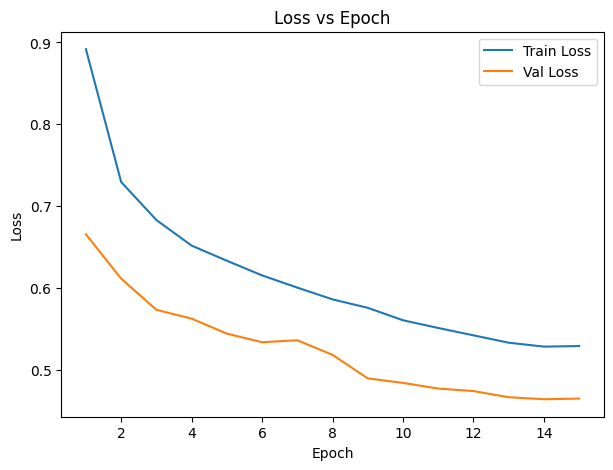

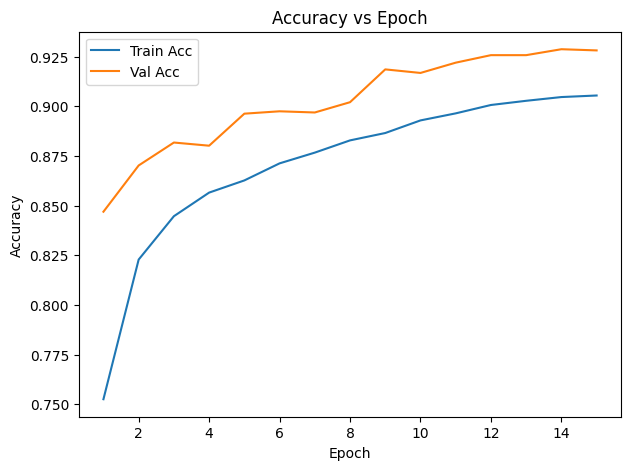

In [ ]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

## 7. Evaluasi pada Test Set

Kita hitung:
- Akurasi test
- Confusion matrix
- Classification report (precision/recall/F1 per kelas)

Test Accuracy: 0.9288


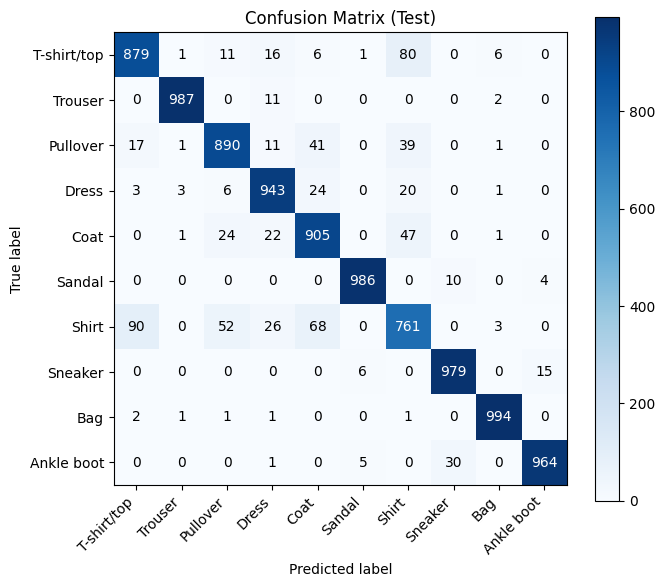

              precision    recall  f1-score   support

 T-shirt/top     0.8870    0.8790    0.8830      1000
     Trouser     0.9930    0.9870    0.9900      1000
    Pullover     0.9045    0.8900    0.8972      1000
       Dress     0.9146    0.9430    0.9286      1000
        Coat     0.8669    0.9050    0.8855      1000
      Sandal     0.9880    0.9860    0.9870      1000
       Shirt     0.8027    0.7610    0.7813      1000
     Sneaker     0.9607    0.9790    0.9698      1000
         Bag     0.9861    0.9940    0.9900      1000
  Ankle boot     0.9807    0.9640    0.9723      1000

    accuracy                         0.9288     10000
   macro avg     0.9284    0.9288    0.9285     10000
weighted avg     0.9284    0.9288    0.9285     10000



In [ ]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

test_preds, test_labels = predict_all(model, test_loader, device)

test_acc = (test_preds == test_labels).mean()
print("Test Accuracy:", test_acc)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")  # <- bikin biru
plt.title("Confusion Matrix (Test)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Tulis angka pada matriks (warna angka menyesuaikan biar kebaca)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(test_labels, test_preds, target_names=class_names, digits=4)
print(report)


## 8. Latihan

Coba modifikasi dan amati dampaknya:
1. Matikan augmentasi (ganti `train_transform` jadi `test_transform`) dan bandingkan akurasinya.
2. Ubah hyperparameter: `lr`, `epochs`.
3. Coba optimizer lain: `SGD(momentum=0.9)` atau `AdamW`.
